In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm_auto

In [2]:
# Create an empty simulation
sim: rebound.Simulation = rebound.Simulation()

# Set preferred units
sim.units = ('day', 'AU', 'Msun')

# Sun and Eight Planets from Horizons

In [3]:
# Set the date to MJD = 59000.0
mjd = 59000.0
jd = 2400000.5 + mjd
date: str = f'JD{jd}'

# Set the simulation time to match the MJD
sim.t = mjd

# Set internal timestep dt
sim.dt = 1.0/16.0

In [4]:
# List of body names
body_names = [
    'Sun', 
    'Mercury', 
    'Venus Barycenter', 
    'Earth', 
    'Moon', 
    'Mars Barycenter', 
    'Jupiter Barycenter', 
    'Saturn Barycenter',
    'Uranus Barycenter',
    'Neptune Barycenter',
    ]

In [5]:
# List of Horizon names
horizon_names = list(body_names)

# Replace 'Earth' and 'Moon' with numerical entries
# Otherwise horrible text query maps them both to EMB (ugh!!!)
horizon_names[3] = '399'
horizon_names[4] = '301'

In [6]:
# List of JPL body IDs
body_ids = [10, 100, 200, 399, 301, 400, 500, 600 , 700, 800]
body_id_strs = [str(body_id) for body_id in body_ids]

In [7]:
# List of short names
short_names = [str.split(body_name)[0] for body_name in body_names]

# Map from short body name to integer offset
name2idx = {k: v for v, k in enumerate(short_names)}

In [8]:
# # Add the selected bodies
# for horizon_name in horizon_names:
#     sim.add(horizon_name, date=date)

In [9]:
# Save this simulation to disk
# sim.save(filename='planets_59000.bin')

In [10]:
# Load the simulation from disk
sim = rebound.Simulation('planets_59000.bin')

# Integrate this system for 100 years daily

### Save the results into Numpy arrays at daily intervals

In [11]:
# Set the number of years
n_year: int = 10

# Set the number of days (integer)
M: np.int32 = np.round(n_year*365.25).astype(np.int32)+1

# The number of particles in the simulation
N: np.int32 = np.int32(sim.N)

# Allocate position and velocity arrays
q: np.ndarray = np.zeros((M,3*N), dtype=np.float64)
v: np.ndarray = np.zeros((M,3*N), dtype=np.float64)

# Create array of times
ts = np.arange(mjd, mjd+M)

In [12]:
# Integrate the simulation and save the state vectors
idx = tqdm_auto(list(enumerate(ts)))
for i, t in idx:
    # Integrate to the current time step with an exact finish time
    sim.integrate(t, exact_finish_time=1)
    # Save the position
    sim.serialize_particle_data(xyz=q[i])
    # Save the velocity
    sim.serialize_particle_data(vxvyvz=v[i])

  0%|          | 0/3653 [00:00<?, ?it/s]

# Helper function - extract position of selected body

In [14]:
def body_slice(data, short_name):
    """
    Return Mx3 array  for selected body
    INPUTS:
        data: Mx3N array of position or velocity data
        short_name: name of the body, e.g. 'Earth' or 'Sun'
    """
    # Get the body index
    r = name2idx[short_name]
    # Get the start and end columns
    j0: int = 3*r
    j1: int = j0+3
    # Return the relevant slice of data array
    return data[:, j0:j1]
    

# Visualize the Results

In [28]:
# Array of times in years
yr = (ts - mjd) / 365.25

# Unpack position of Earth, Mars and Jupiter
qEarth = body_slice(q, 'Earth')
qMars = body_slice(q, 'Mars')
qJupiter = body_slice(q, 'Jupiter')

# Distance from Earth to Mars
r_mars = np.linalg.norm(qMars-qEarth, axis=1)

# Distance from Earth to Jupiter
r_jupiter = np.linalg.norm(qJupiter-qEarth, axis=1)

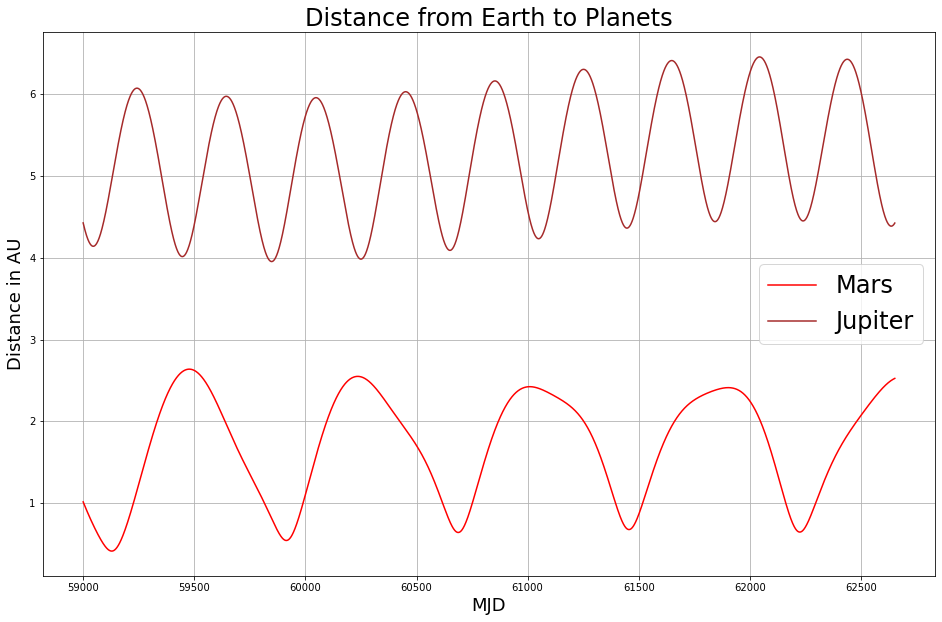

In [31]:
# Plot Distance from Earth to planets
fig, ax = plt.subplots(figsize=[16,10])
ax.set_title('Distance from Earth to Planets', fontsize=24)
ax.plot(ts, r_mars, label='Mars', color='red')
ax.plot(ts, r_jupiter, label='Jupiter', color='brown')
ax.set_xlabel('MJD', fontsize=18)
ax.set_ylabel('Distance in AU', fontsize=18)
ax.grid(True)
ax.legend(fontsize=24)
plt.show()

In [34]:
fig.savefig('figs/plot_02.png', bbox_inches='tight')